# Inspect the leaf-level interpolation
I (Olivia) had trouble recreating the leaf-level interpolation from Chebyshev points, so in this notebook I seek to recover the original interpolation behavior.

In the end, I am not sure I got the orientation of the overall leaf correct (it will be easier to check this in the multi-leaf case). However, I think I understand now how to use the interpolation matrix.

When calling `rearrange_indices_ext_int`, the provided matrix is of shape $n^2 \times p^2$, if $n$ is the desired number of points per uniform grid dimension in the output, and $p$ is the number of points per Chebyshev grid dimension in the input. This matrix assumes the basic ordering suggested by a meshgrid of the two dimensions' gridpoints.
However, since the HPS quadtree utilizes a re-arranged ordering in order to place boundary values at the beginning, it is necessary -- when working with leaves of the HPS quadtree -- to permute the indices of the interpolation matrix using the `rearrange_indices_ext_int[_{2,3}D]` function.

In [1]:
import os
import jax
import jax.numpy as jnp
from scipy.io import savemat
import matplotlib.pyplot as plt

import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)

2025-06-19 13:24:17.456:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-19 13:24:17.458:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-19 13:24:17.459:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-19 13:24:17.460:jaxhps: DEBUG - Creating converter from 5 to 7


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from timeit import default_timer
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)
from src.jaxhps import (
    Domain as MyDomain,
    DiscretizationNode2D as MyDiscretizationNode2D
)
from src.jaxhps._grid_creation_2D import rearrange_indices_ext_int as rearrange_indices_ext_int_2D
from jaxhps.quadrature import barycentric_lagrange_interpolation_matrix_2D, chebyshev_points
INTERP_BATCH_SIZE = 20

In [36]:
q_fn_handle = lambda x: q_gaussian_bumps(0.6 * x)
domain_bounds = jnp.array([-1., 1., -1., 1.])

In [46]:
leaf_root = DiscretizationNode2D(-1., 1., -1., 1.)
leafp = 16
leaf_domain = Domain(p=leafp, q=leafp-2, root=leaf_root, L=0)

leaf_unif_n   = 24
leaf_unif_pts = jnp.linspace(-1, 1, leaf_unif_n, endpoint=False)
leaf_unif_xy  = jnp.array(jnp.meshgrid(leaf_unif_pts, leaf_unif_pts, indexing="ij")).transpose(1,2,0)
q_leaf_unif = q_fn_handle(leaf_unif_xy)

In [47]:
# Get the interior points on the chebyshev grid as represented in the Domain object
ref_leaf_cheb_pts = leaf_domain.interior_points.reshape(-1, 2)
ref_q_leaf_cheb   = q_fn_handle(ref_leaf_cheb_pts)

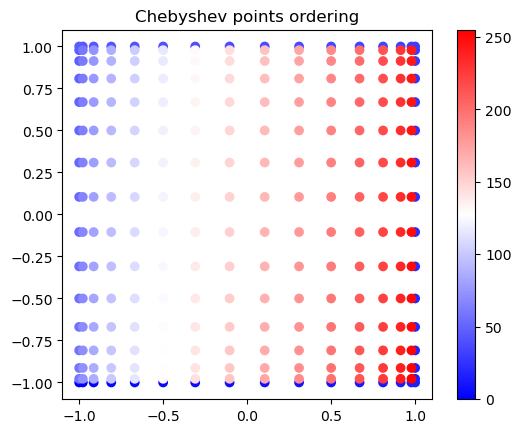

In [48]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev points ordering")
plt.scatter(*ref_leaf_cheb_pts[vis_slice].T, c=jnp.arange(ref_leaf_cheb_pts.shape[0])[vis_slice], cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

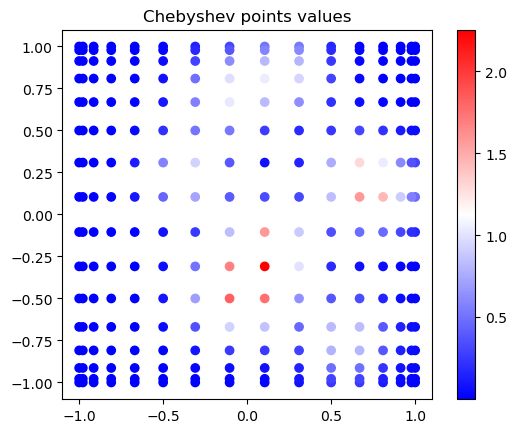

In [63]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev points values")
plt.scatter(*ref_leaf_cheb_pts[vis_slice].T, c=jnp.real(ref_q_leaf_cheb), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## Try to use the original code for interpolation

In [61]:
out_vals, target_pts = leaf_domain.interp_from_interior_points(
    samples=ref_q_leaf_cheb[jnp.newaxis, :], eval_points_x=leaf_unif_pts, eval_points_y=leaf_unif_pts
)

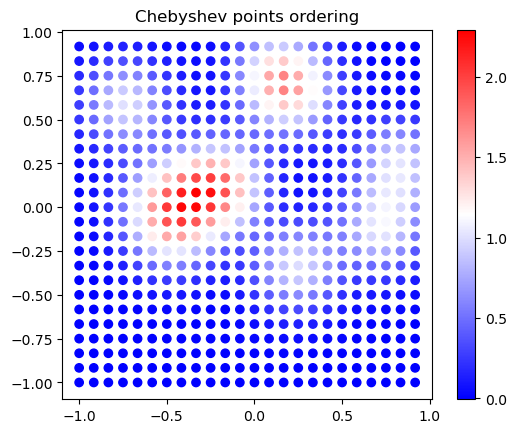

In [62]:
vis_slice = jnp.s_[:]
plt.title(f"Chebyshev points ordering")
plt.scatter(*target_pts[vis_slice].T, c=jnp.real(out_vals)[vis_slice], cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

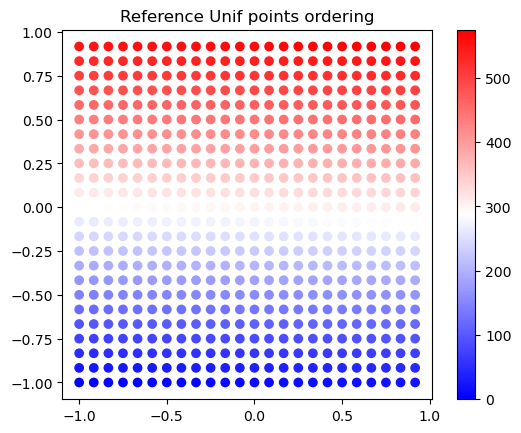

In [84]:
vis_slice = jnp.s_[:]
plt.title(f"Reference Unif points ordering")
plt.scatter(*target_pts.reshape(-1, 2)[vis_slice].T, c=jnp.arange(jnp.real(out_vals).size)[vis_slice], cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [95]:
rearrange_idcs = rearrange_indices_ext_int_2D(leafp)

In [130]:
rearranged_interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y[::-1],
    to_pts_x=leaf_unif_pts,
    to_pts_y=leaf_unif_pts[::-1],
)[:, rearrange_idcs]
rearranged_interp_leaf_unif = rearranged_interp_leaf_cheb_to_unif @ ref_q_leaf_cheb

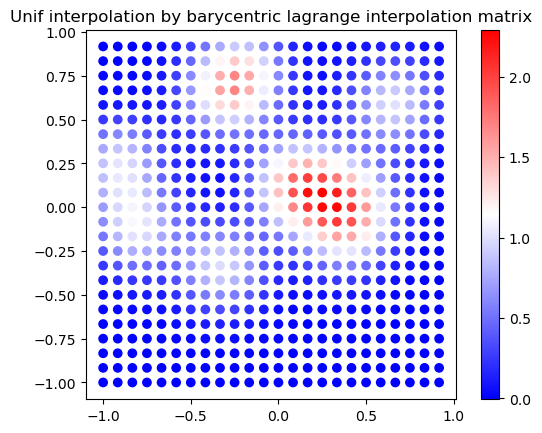

In [135]:
vis_slice = jnp.s_[:]
plt.title(f"Unif interpolation by barycentric lagrange interpolation matrix")
plt.scatter(*leaf_unif_xy[vis_slice].T, c=jnp.real(rearranged_interp_leaf_unif)[vis_slice], cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

## My attempt to recreate the interpolation

In [102]:
# Chebyshev grid setup
leaf_cheb_x = chebyshev_points(leafp)
leaf_cheb_y = chebyshev_points(leafp)
leaf_cheb_xy = jnp.array(jnp.meshgrid(leaf_cheb_x, leaf_cheb_y, indexing="ij")).transpose(1,2,0).reshape(-1, 2)

q_leaf_cheb = q_fn_handle(leaf_cheb_xy)

In [110]:
tmp_interp_leaf_cheb_to_unif.shape

(576, 256)

In [126]:
# Interpolation setup
interp_leaf_cheb_to_unif = barycentric_lagrange_interpolation_matrix_2D(
    from_pts_x=leaf_cheb_x,
    from_pts_y=leaf_cheb_y[::-1],
    to_pts_x=leaf_unif_pts,
    to_pts_y=leaf_unif_pts,
)
# # Just skip the re-arrange step if using leaf_cheb_xy in the way that is not re-arranged
# rearrange_idcs = rearrange_indices_ext_int_2D(leafp)
# interp_leaf_cheb_to_unif = interp_leaf_cheb_to_unif[:, rearrange_idcs]
q_leaf_unif_from_cheb = interp_leaf_cheb_to_unif @ q_leaf_cheb.reshape(-1)

In [127]:
interp_leaf_cheb_to_unif.shape

(576, 256)

In [122]:
q_leaf_cheb.shape

(256,)

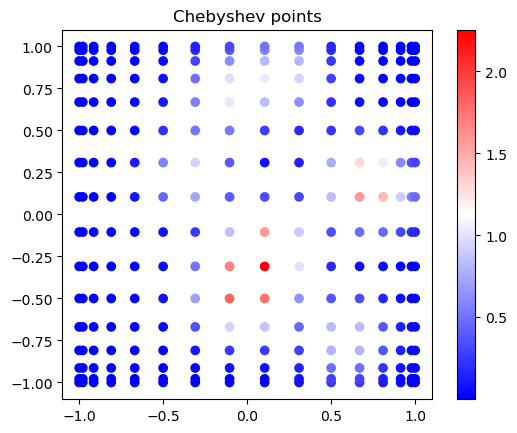

In [123]:
plt.title(f"Chebyshev points")
plt.scatter(*leaf_cheb_xy.reshape(-1,2).T, c=jnp.real(q_leaf_cheb.reshape(-1)), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

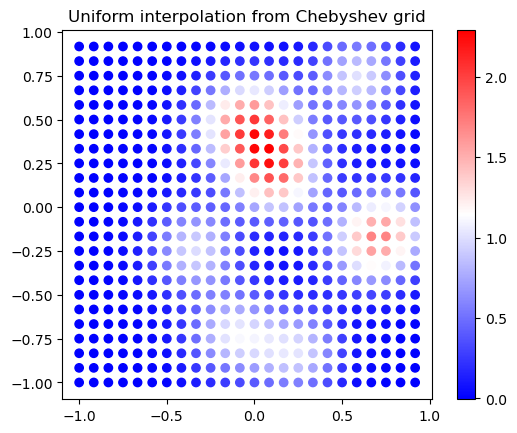

In [124]:
plt.title(f"Uniform interpolation from Chebyshev grid")
plt.scatter(*leaf_unif_xy.reshape(-1,2).T, c=jnp.real(q_leaf_unif_from_cheb), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

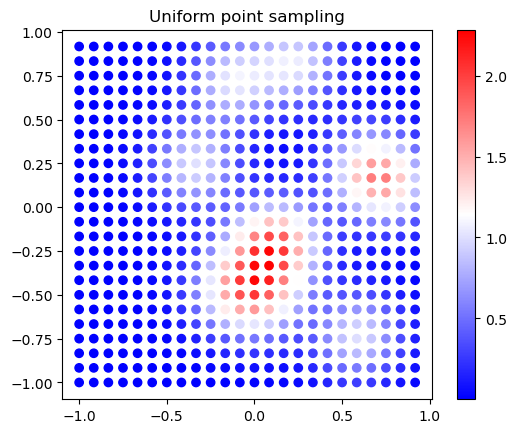

In [125]:
plt.title(f"Uniform point sampling")
# plt.imshow(jnp.real(reordered_uscat_soln[vis_idx, :, src_idx]).reshape(p,p), cmap="bwr")
plt.scatter(*leaf_unif_xy.reshape(-1,2).T, c=jnp.real(q_leaf_unif.reshape(-1)), cmap="bwr")
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()